In [5]:
import sys
print(sys.executable) 

/Users/akshayghosh/acenet_py/deep_learning/.venv/bin/python


IDEA FOR PREDICTING 2024-25 SEASON:

- train model on the 20-21 to 22-23 seasons, make predictions on the 23-24 season

- add in something to take into account for each player the way their distribution of features over each shot, so for example the distribution of the distance of all their shots, the way this changes over time

- use that to predict a distribution for next season

- simualate shot data based on this distribution, so 24-25 simulated data

- calculate the expected goals on this

- can include the residuals over time for predicting individual players goals?

- a combo of the distribution and residual over time to predict the new value which could have a residual compared to if the xgoals were taken at face value

In [6]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression

from scipy.stats import describe

from sklearn.metrics import mean_squared_error, r2_score

# from sklearn.model_selection import GridSearchCV

# from sklearn.base import BaseEstimator, TransformerMixin

# import xgboost as xgb

import torch
import torch.nn as nn
import torch.nn.functional as F

# plot the rink
from hockey_rink import NHLRink, RinkImage

In [7]:
# LOAD DATA

# each season of shooting data for training
fn_shots = ['/Users/akshayghosh/hockey/expected_goals_model/shot_data/shots_2020_2021.csv', 
            '/Users/akshayghosh/hockey/expected_goals_model/shot_data/shots_2021_2022.csv', 
            '/Users/akshayghosh/hockey/expected_goals_model/shot_data/shots_2022_2023.csv']

# read each CSV file into a DataFrame and concatenate them
data = pd.concat([pd.read_csv(file) for file in fn_shots], ignore_index=True)
data = data[data['isPlayoffGame'] == 0] # select only regular season games
# data = data[data['shotOnEmptyNet'] == 0] # decided to include empty net goals
data = data[~data['lastEventCategory'].isin(['PEND', 'GEND', 'EGT'])]

# make predictions on last year of data
fn_predict = '/Users/akshayghosh/hockey/expected_goals_model//shot_data/shots_2023_2024.csv'
data_predict = pd.read_csv(fn_predict)
data_predict = data_predict[data_predict['isPlayoffGame'] == 0]
# data_predict = data_predict[data_predict['shotOnEmptyNet'] == 0]

In [8]:
np.shape(data) # look at size of the array

(298451, 137)

In [9]:
# print cols

for col in data.columns:
    # Access the data type using 'df[col].dtype'
    dtype = data[col].dtype
    # Count NaN values using 'df[col].isna().sum()'
    nan_count = data[col].isna().sum()
    # print(f"NaN Count: {nan_count}      Column Name: {col},         Data Type: {dtype}")

'''
noteable nans:

NaN Count: 298464      Column Name: gameOver
NaN Count: 1889      Column Name: goalieNameForShot,         Data Type: object
NaN Count: 298464      Column Name: homeTeamScore,         Data Type: float64
NaN Count: 298464      Column Name: homeWinProbability,         Data Type: float64
NaN Count: 298464      Column Name: penaltyLength,         Data Type: float64
NaN Count: 0      Column Name: period,         Data Type: int64
NaN Count: 25      Column Name: playerPositionThatDidEvent,         Data Type: object
NaN Count: 298464      Column Name: playoffGame,         Data Type: float64
NaN Count: 298464      Column Name: roadTeamCode,         Data Type: float64
NaN Count: 298464      Column Name: roadTeamScore,         Data Type: float64
NaN Count: 50      Column Name: shooterLeftRight,         Data Type: object
NaN Count: 39      Column Name: shooterName,         Data Type: object
NaN Count: 38      Column Name: shooterPlayerId,         Data Type: float64
NaN Count: 298464      Column Name: shotGoalProbability,         Data Type: float64
NaN Count: 298464      Column Name: shotPlayContinued,         Data Type: float64
NaN Count: 817      Column Name: shotType,         Data Type: object
NaN Count: 298464      Column Name: timeBetweenEvents,         Data Type: float64
NaN Count: 298464      Column Name: timeLeft,         Data Type: float64
NaN Count: 298464      Column Name: wentToOT,         Data Type: float64
NaN Count: 298464      Column Name: wentToShootout,         Data Type: float64
'''
None


In [10]:
# select parameters
# target is 'goal'

y = data['goal']

# feature_names = ['xCordAdjusted',
#                  'yCordAdjusted',
#                  'shotAngle',
#                  'shotAnglePlusRebound',
#                  'shotDistance',
#                  'shotType',
#                  'shotRebound',
#                  'shotAnglePlusReboundSpeed',
#                  'shotRush',
#                  'speedFromLastEvent',
#                  'lastEventCategory',
#                  'shooterTimeOnIce',
#                  'shootingTeamAverageTimeOnIceOfForwards',
#                  'shootingTeamAverageTimeOnIceOfDefencemen',
#                  'offWing',
#                  'timeDifferenceSinceChange']

# feature_names = ['shotAngle',
#                  'shotDistance']

feature_names = ['timeSinceLastEvent', # Time between the shot and the event that took place before the shot
                 'shotAngle', # The angle of the shot in degrees. Is a positive number if the shot is from the left side of the ice. 
                 'shotAnglePlusRebound',# The angle of the shot in degrees. Is a positive number if the shot is from the left side of the ice. 
                 'shotAngleReboundRoyalRoad', # Set to 1 if the puck went through the middle of the between this shot and previous shot if this shot is a rebound.
                 'shotDistance', # The distance from the net of the shot in feet. Net is defined as being at the (89,0) coordinates
                 'shotType', # Type of the shot. (Slap, Wrist, etc)
                 'shotRebound', # Set to 1 if the shot is a rebound. (If the last event was a shot and within 3 seconds of this shot)
                 'shotAnglePlusReboundSpeed', # The shotAnglePlusRebound variable divded by time between the last shot and this one. (How fast the angle changed)
                 'shotRush', # Set to 1 if the shot was on a rush. (If the last event was in another zone and within 4 seconds)
                 'speedFromLastEvent', # The distance between the shot location and the previous event's location divded by the number of seconds between them
                 'distanceFromLastEvent', # The distance between the shot location and the previous event's location in feet
                 'lastEventShotAngle', # The shot angle of the shot directly before this shot. (If the last event was a shot)
                 'lastEventShotDistance', # The shot distance of the shot directly before this shot. (If the last event was a shot)
                 'lastEventCategory', # The type of event before the shot.Shot, hit, etc. 
                 #'goalieNameForShot', # The First and Last name of the goalie the shot is on.
                 'shooterTimeOnIce', # playing time in seconds that have passed since the shooter started their shift
                 'shootingTeamAverageTimeOnIce', # The average playing time in seconds the shooting team's players have been on the ice
                 'defendingTeamAverageTimeOnIce', # The average playing time in seconds the shooting team's players have been on the ice
                 'offWing', # Set to 1 if the shot is from the left side of the ice and the shooter is a right shot, or vice-versa. Otherwise 0
                 'shotOnEmptyNet'] # set to 0 if the net is empty, 1 if non-empty

# add way more features, that is what NN's are good at

print(len(feature_names))

X = data[feature_names]

X_predict = data_predict[feature_names]

p_num = X.select_dtypes(include=['int64', 'float64'])
p_cat = X.select_dtypes(include=['object'])

19


In [11]:
print(p_num.columns)
print(p_cat.columns)

Index(['timeSinceLastEvent', 'shotAngle', 'shotAnglePlusRebound',
       'shotAngleReboundRoyalRoad', 'shotDistance', 'shotRebound',
       'shotAnglePlusReboundSpeed', 'shotRush', 'speedFromLastEvent',
       'distanceFromLastEvent', 'lastEventShotAngle', 'lastEventShotDistance',
       'shooterTimeOnIce', 'shootingTeamAverageTimeOnIce',
       'defendingTeamAverageTimeOnIce', 'offWing', 'shotOnEmptyNet'],
      dtype='object')
Index(['shotType', 'lastEventCategory'], dtype='object')


In [12]:
'''
in the cat cols, number of distinct vals:
shotType: 2
lastEventCategory: 13
goalieNameForShot: 149
'''

'\nin the cat cols, number of distinct vals:\nshotType: 2\nlastEventCategory: 13\ngoalieNameForShot: 149\n'

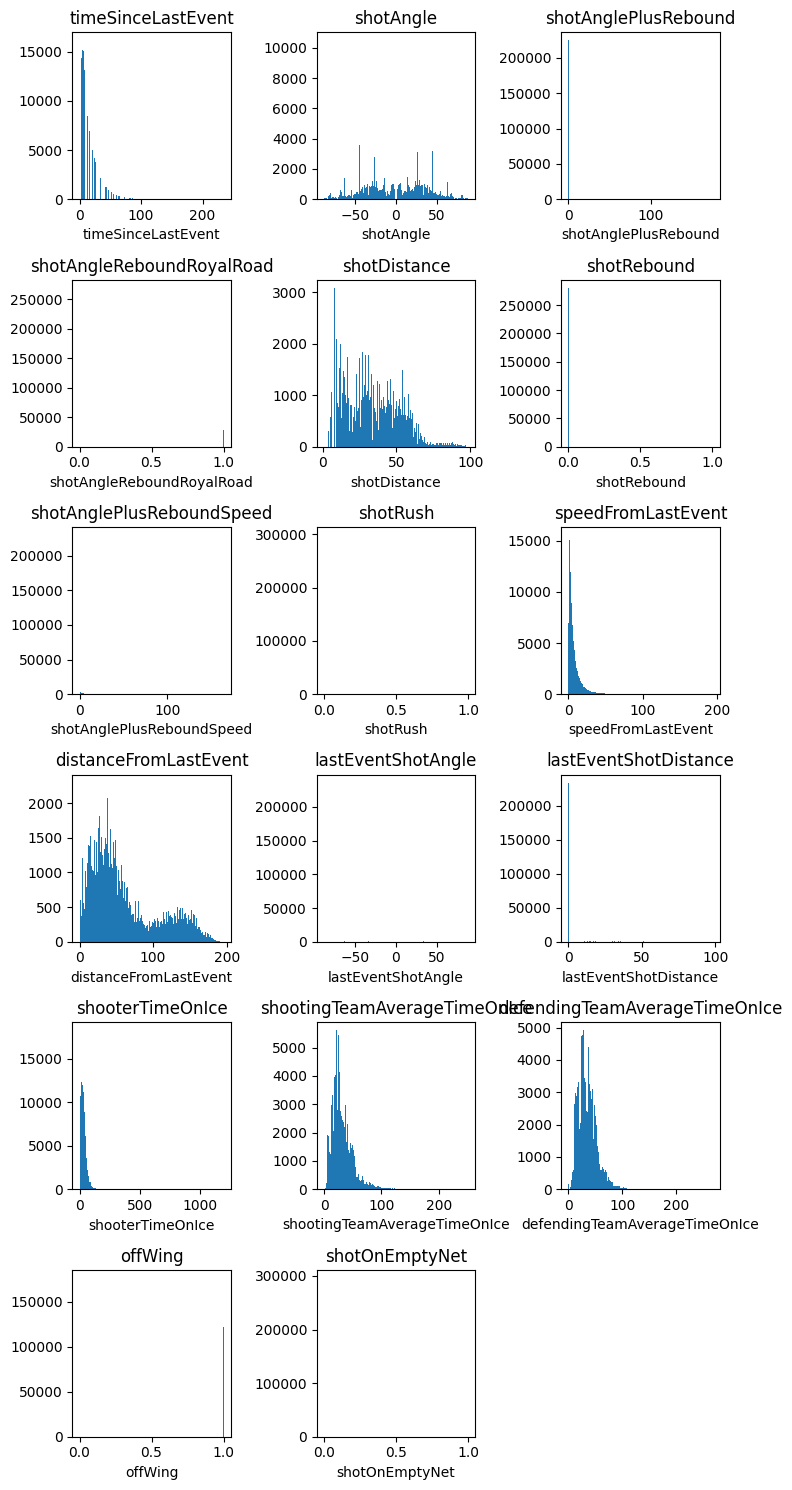

In [13]:
# EDA, look at distributions

number_of_bins = int(np.sqrt(np.shape(data)[0])/1)

rows, cols = int(np.ceil(len(p_num.columns) / 3)), 3  # Calculate rows and columns

fig, axes = plt.subplots(rows, cols, figsize=(15/2, rows * 5/2))  # Create subplots

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Loop through columns and create histograms
for i, col in enumerate(p_num.columns):
    if i < len(p_num.columns):  # Check if within data range
        data_col = data[col]
        axes[i].hist(data_col, bins=number_of_bins)
        axes[i].set_xlabel(col)
        axes[i].set_title(col)  # Add title for each plot

# Adjust layout for unequal plots (optional)
if len(p_num.columns) % 3 == 1:
    # Hide unused axes in the last row
    for ax in axes[-2:]:
        ax.axis('off')
elif len(p_num.columns) % 3 == 2:
    # Hide the unused axis in the last row
    axes[-1].axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [14]:
print(f'number of numerical cols = {len(p_num.columns)}')
print(f'number of categorical cols = {len(p_cat.columns)}')

number of numerical cols = 17
number of categorical cols = 2


In [15]:
class NeuralNetwork1(nn.Module):
    # input layer, has 4 features of the iris flower)
    # so has
    # Hidden Layer1 (number of neurons) -->
    # Hidden Layer2(n) -->
    # output (3 classes of flowers)


    # here set the number of input features, neurons for hidden layers, number of output features
    def __init__(self,in_features = 34, h1 = 10, h2 = 10, out_features = 1):
        
        super().__init__() # instantiate our nn.Module, maybe try to understand this more
        
        # fc1 means fully connected layer 1
        self.fc1 = nn.Linear(in_features, h1) # this connects the input layer with hidden layer 1 aka h1
        self.fc2 = nn.Linear(h1,h2) # connects h1 to h2
        self.out = nn.Linear(h2, out_features) # connects h2 to output

    def forward(self,x):
        x = F.relu(self.fc1(x)) # relu is the activation function so for x < a, set x = 0
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x))
        return(x)

In [16]:
class NeuralNetwork2(nn.Module):
    # input layer, has 4 features of the iris flower)
    # so has
    # Hidden Layer1 (number of neurons) -->
    # Hidden Layer2(n) -->
    # output (3 classes of flowers)


    # here set the number of input features, neurons for hidden layers, number of output features
    def __init__(self,in_features = 34, h1 = 100, h2 = 50, out_features = 1):
        
        super().__init__() # instantiate our nn.Module, maybe try to understand this more
        
        # fc1 means fully connected layer 1
        self.fc1 = nn.Linear(in_features, h1) # this connects the input layer with hidden layer 1 aka h1
        self.fc2 = nn.Linear(h1,h2) # connects h1 to h2
        self.out = nn.Linear(h2, out_features) # connects h2 to output

    def forward(self,x):
        x = F.relu(self.fc1(x)) # relu is the activation function so for x < a, set x = 0
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x))
        return(x)

In [17]:
class NeuralNetwork3(nn.Module):
    # input layer, has 4 features of the iris flower)
    # so has
    # Hidden Layer1 (number of neurons) -->
    # Hidden Layer2(n) -->
    # output (3 classes of flowers)


    # here set the number of input features, neurons for hidden layers, number of output features
    def __init__(self,
                 in_features = 34, 
                 h1 = 400, 
                 h2 = 300,
                 h3 =  200,
                 h4 =  100,
                 h5 =  50,
                 h6 =  25,
                 h7 = 5,
                 out_features = 1):
        
        super().__init__() # instantiate our nn.Module, maybe try to understand this more
        
        # fc1 means fully connected layer 1
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,h3)
        self.fc4 = nn.Linear(h3,h4)
        self.fc5 = nn.Linear(h4,h5)
        self.fc6 = nn.Linear(h5,h6)
        self.fc7 = nn.Linear(h6,h7)
        self.out = nn.Linear(h7, out_features)

    def forward(self,x):
        x = F.relu(self.fc1(x)) # relu is the activation function so for x < a, set x = 0
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = torch.sigmoid(self.out(x))
        return(x)

In [18]:
class NeuralNetwork4(nn.Module):
    # input layer, has 4 features of the iris flower)
    # so has
    # Hidden Layer1 (number of neurons) -->
    # Hidden Layer2(n) -->
    # output (3 classes of flowers)


    # here set the number of input features, neurons for hidden layers, number of output features
    def __init__(self,
                 in_features = 35, 
                 h1 = 400, 
                 h2 = 200,
                 h3 =  25,
                 h4 =  5,
                 out_features = 1):
        
        super().__init__() # instantiate our nn.Module, maybe try to understand this more
        
        # fc1 means fully connected layer 1
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,h3)
        self.fc4 = nn.Linear(h3,h4)
        self.out = nn.Linear(h4, out_features)

    def forward(self,x):
        x = F.relu(self.fc1(x)) # relu is the activation function so for x < a, set x = 0
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.out(x))
        return(x)

In [19]:
# define data preprocessing, scale the numerical cols and encode the categorical cols

preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), p_num.columns),
    ('cat_encoder', OneHotEncoder(), p_cat.columns)
])

In [20]:
print(np.shape(X))
print(np.shape(X_predict))

# shotType: 2
# lastEventCategory: 13

print(X['shotType'].unique(),len(X['shotType'].unique()))
print(X['lastEventCategory'].unique(),len(X['lastEventCategory'].unique()))

print(X_predict['shotType'].unique(),len(X_predict['shotType'].unique()))
print(X_predict['lastEventCategory'].unique(),len(X_predict['lastEventCategory'].unique()))

(298451, 19)
(114783, 19)
['WRIST' 'BACK' 'SNAP' 'SLAP' 'TIP' 'WRAP' 'DEFL' nan] 8
['FAC' 'BLOCK' 'HIT' 'GIVE' 'SHOT' 'MISS' 'TAKE' 'DELPEN' 'CHL' 'STOP'] 10
['WRIST' 'TIP' 'SNAP' 'SLAP' nan 'BACK' 'DEFL' 'WRAP'] 8
['GIVE' 'SHOT' 'HIT' 'TAKE' 'MISS' 'FAC' 'BLOCK' 'DELPEN' 'STOP' 'CHL'] 10


In [21]:
# drop 'PEND','GEND','EGT' from X

In [22]:
# sorted(X['shotType'].unique())

In [23]:
# execute data preprocessing

# X = X[~X['lastEventCategory'].isin(['PEND', 'GEND', 'EGT'])] # need to remove these rows, think of a way to automate this
# y = y[~X['lastEventCategory'].isin(['PEND', 'GEND', 'EGT'])]

X = preprocessor.fit_transform(X) # this transforms X into a np array
X_predict = preprocessor.fit_transform(X_predict)

In [24]:
print(np.shape(X))
print(np.shape(X_predict))

(298451, 35)
(114783, 35)


In [25]:
# convert to numpy arrays
# X = X.values
y = y.values
# X_predict = X_predict.values

# split dataset into training and testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1997, shuffle = True)

In [26]:
# need X and y to be pytorch tensors
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_predict = torch.FloatTensor(X_predict)

y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)

In [27]:
# need to give random seed, used 41 in lesson
torch.manual_seed(1997)

# create instance of model
model = NeuralNetwork4()

In [28]:
np.shape(X_train)

torch.Size([238760, 35])

In [29]:
# now set criterion of model to measure the error, so like how far off the predictions are
# criterion = nn.CrossEntropyLoss() # this is for when you have more than 2 target classes
criterion = nn.BCELoss()

# choose optimizer, choose adam, also choose learning rate lr
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01) # lower the lr, the longer it will take to learn
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0)

In [30]:
# train our model
# number of epochs? an epoch is a run through all the training data in the network

epochs = 100
losses = []

for i in range(epochs):
    # print(f'EPOCH = {i}')
    # go forward and get prediction
    y_train_calc = model.forward(X_train) # get predicted results

    # measure loss,error, gonna be high at first
    loss = criterion(y_train_calc,y_train.unsqueeze(1).float()) # predicted values vs the y_train

    # keep track of losses
    # losses.append(loss.detach().numpy)
    losses.append(loss.item())

    # print every 10 epochs
    if i % 10 == 0:
        print(f'epoch {i} has loss {loss}')

    #  now do back propagation: take the error rate of forward prop and feed it back through the network to fine tune the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


epoch 0 has loss 0.8116960525512695
epoch 10 has loss 0.2718757092952728
epoch 20 has loss 0.24164453148841858
epoch 30 has loss 0.22870804369449615
epoch 40 has loss 0.22765487432479858
epoch 50 has loss 0.22655802965164185
epoch 60 has loss 0.22573013603687286
epoch 70 has loss 0.2251819670200348
epoch 80 has loss 0.22472865879535675
epoch 90 has loss 0.22431209683418274


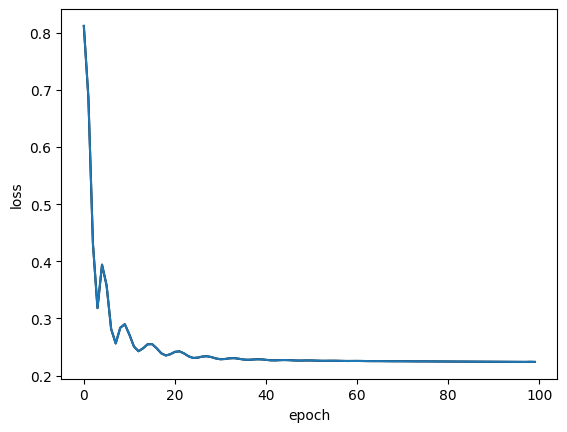

In [31]:
# plot the losses
plt.figure(dpi = 100)
plt.plot(range(epochs),losses,'k-')
plt.plot(np.array(losses))
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.xscale('log');plt.yscale('log')
plt.show()

- people will often plot loss over epochs
- since i have a lot of data can add more epochs. there is a way to figure this out
- make a plot of dist of xGoals
- add actual goals to the table
- before sending notebook, add a lot more text blocks explaing stuff
- get rid of the unessecary tables
- commented out stuff that is commentary put in a text block
- explain the plots better
- there is a package called autoML or something for testing different ML configurations

In [32]:
with torch.no_grad(): # basically turn off back propagation
    y_val_calc = model.forward(torch.tensor(X_val,dtype=torch.float32))
    loss_test = criterion(y_val_calc,y_val.unsqueeze(1).float()) # find the loss aka error

print(loss_test)

/var/folders/71/z2b6hqb108nd483c893k6znc0000gn/T/ipykernel_19603/2853912849.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_calc = model.forward(torch.tensor(X_val,dtype=torch.float32))


tensor(0.2233)


In [33]:
# make predictions on 2023-24 data
with torch.no_grad(): # basically turn off back propagation
    y_pred = model.forward(torch.tensor(X_predict,dtype=torch.float32))

/var/folders/71/z2b6hqb108nd483c893k6znc0000gn/T/ipykernel_19603/2220095087.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model.forward(torch.tensor(X_predict,dtype=torch.float32))


In [34]:
'''
add the calculated xgoal to the dataframe and compare
'''

pd.set_option("display.max_rows", None)

df = data_predict

pred_xgoal = y_pred

df['pred_xgoal'] = pred_xgoal

# for col in df.keys():print('{:<50}  {:>50}'.format(col , df[col][0]))

grouped_pred = df.groupby('shooterName').agg({'xGoal': 'sum', 'goal': 'sum', 'pred_xgoal': 'sum'})
grouped_pred['goal_residual'] = grouped_pred['goal'] - grouped_pred['xGoal']
grouped_pred['pred_goal_residual'] = grouped_pred['goal'] - grouped_pred['pred_xgoal'] # add new col that is total goals - xgoals
grouped_pred['residual_difference'] = grouped_pred['pred_goal_residual'] - grouped_pred['goal_residual']    
    
# print biggest discrepencies between goals and xgoals
sorted_grouped_pred = grouped_pred.sort_values(by='pred_goal_residual', ascending=True)

# print out the top 30 shooterName values, their cumulative xGoal, and sum of 'goal'
print('shooterName             AG: cumulative xGoal           Goals    Goals - xGoals')
print('--------------------------------------------------------------------------------')
for index, row in sorted_grouped_pred.head(20).iterrows():
    print('{:<25}  {:>15}  {:>15}  {:>15}'.format(index, round(row['pred_xgoal'],3), int(row['goal']), round(row['pred_goal_residual'],3)))
    
print()
    
print('shooterName             AG: cumulative xGoal           Goals    Goals - xGoals')
print('--------------------------------------------------------------------------------')
for index, row in sorted_grouped_pred.tail(20)[::-1].iterrows():
    print('{:<25}  {:>15}  {:>15}  {:>15}'.format(index, round(row['pred_xgoal'],3), int(row['goal']), round(row['pred_goal_residual'],3)))

shooterName             AG: cumulative xGoal           Goals    Goals - xGoals
--------------------------------------------------------------------------------
Josh Anderson                        21.45                9           -12.45
Miles Wood                          19.318                9          -10.318
Sean Couturier                      19.738               10           -9.738
John Tavares                        38.614               29           -9.614
Vincent Trocheck                    34.486               25           -9.486
Matthew Tkachuk                     35.398               26           -9.398
Yanni Gourde                         20.31               11            -9.31
Taylor Raddysh                      14.183                5           -9.183
Ryan Nugent-Hopkins                 26.811               18           -8.811
Adam Lowry                          19.659               11           -8.659
Jake Guentzel                       38.646               30           

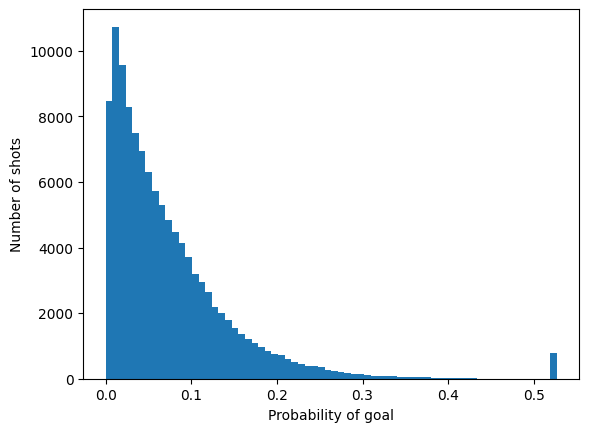

In [35]:
number_of_bins = int(np.sqrt(np.shape(data)[0])/8)

plt.figure(dpi = 100)
plt.hist(y_pred.numpy(), bins = number_of_bins)
plt.xlabel('Probability of goal')
plt.ylabel('Number of shots')
plt.show()

In [36]:
# for col in df.columns:
#     print(col)

In [37]:
df.head()

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,...,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted,pred_xgoal
0,0,39.698866,59.0,59.0,-26.0,26.0,-3.4,0,0,0,...,0.249174,0.035813,0.379310,0.277143,0.022744,0.035816,0.751320,-26,-26,0.062273
1,1,11.313708,81.0,81.0,8.0,8.0,-3.4,0,0,0,...,0.107945,0.057705,0.464358,0.298119,0.020588,0.051284,0.589712,8,8,0.084944
2,2,45.343136,55.0,55.0,30.0,30.0,-3.8,0,0,0,...,0.236193,0.016126,0.390417,0.301375,0.025621,0.030269,0.785765,30,30,0.019724
3,3,43.139309,58.0,58.0,-30.0,30.0,-3.4,0,0,0,...,0.198635,0.016797,0.438052,0.291724,0.021107,0.033686,0.724471,-30,-30,0.026294
4,4,42.201896,-64.0,64.0,34.0,34.0,-15.0,0,0,0,...,0.188582,0.008709,0.406288,0.349752,0.019523,0.027146,0.727481,34,-34,0.012002


In [38]:
def generate_rink_from_logo(home,away,rotation = 0):
    '''
    create rink to plot
    '''
    
    rink = NHLRink(
        home_logo={
            "feature_class": RinkImage,
            "image_path": 'https://upload.wikimedia.org/wikipedia/en/thumb/3/3a/05_NHL_Shield.svg/1782px-05_NHL_Shield.svg.png',
            "x": 7, "length": get_logo_size(home)[0], "width": get_logo_size(home)[1], # "x": 7, "length": 50/4, "width": 42/4, <- FOR SENS LOGO
            "zorder": 15, "alpha": 0.5,
        },
        away_logo={
            "feature_class": RinkImage,
            "image_path": 'https://upload.wikimedia.org/wikipedia/en/thumb/3/3a/05_NHL_Shield.svg/1782px-05_NHL_Shield.svg.png',
            "x": -7, "length": get_logo_size(away)[0], "width": get_logo_size(away)[1],
            "zorder": 15, "alpha": 0.5,
        },
        rotation = rotation
    )
    
    return(rink)

def get_logo_size(team):
    '''
    this is because the sens logo appears warped, test to see if needed for any other logos
    so far, BOS, TOR, NHL all work
    '''
    if team == 'OTT':
        length = 50/4
        width = 42/4
    else:
        length = 42/4
        width = 42/4
    
    return(length,width)

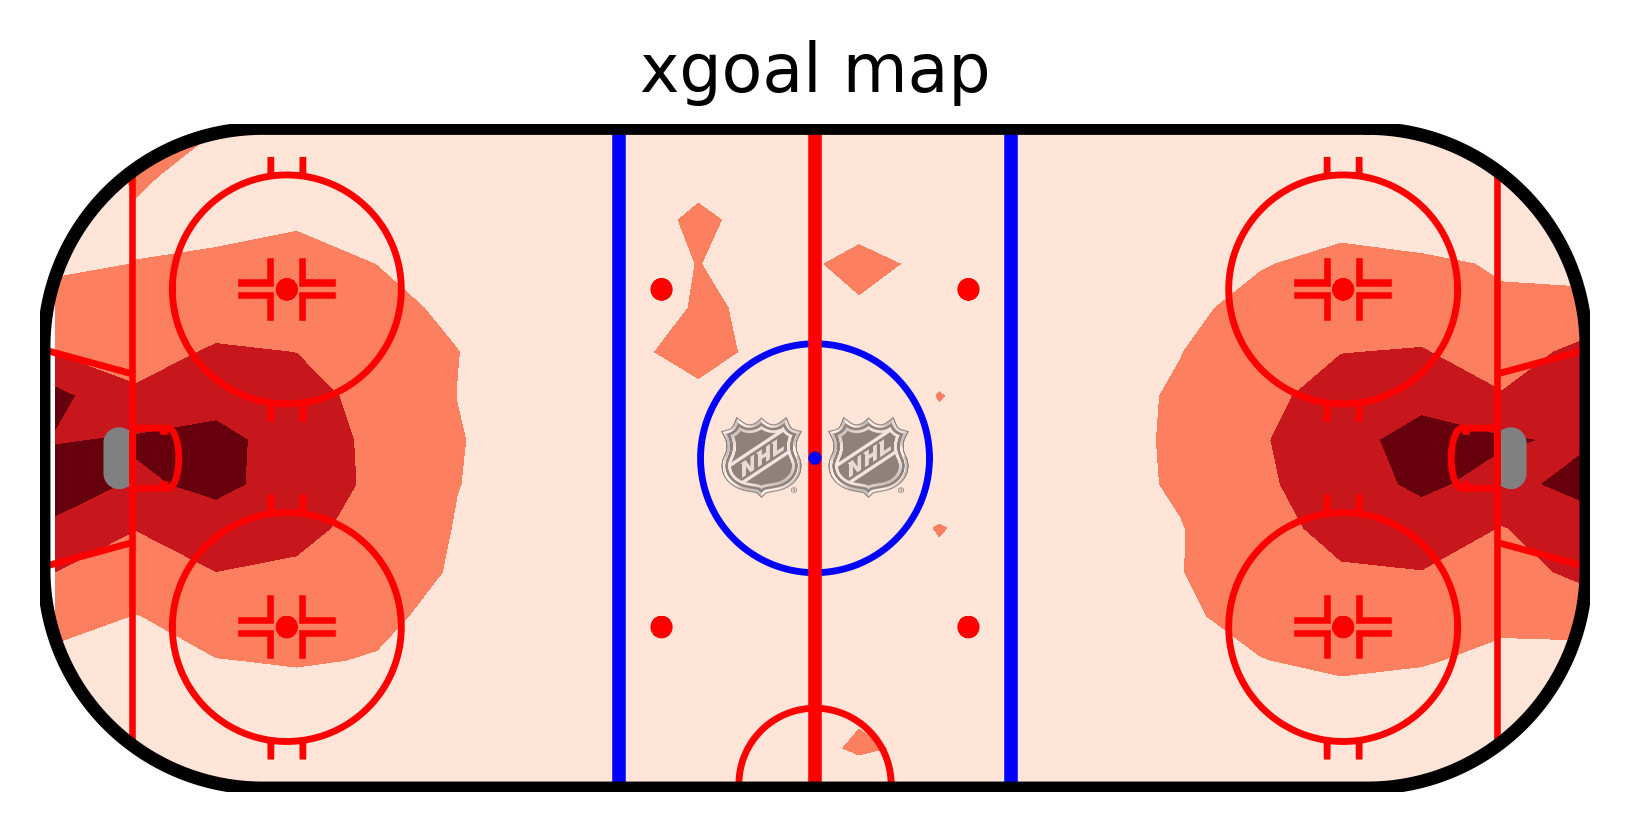

In [39]:
rink = generate_rink_from_logo(home = 'NHL',away = 'NHL')

# get x,y coordinates and z = f(x,y)
x_coords = df['arenaAdjustedXCord'].values
y_coords = df['arenaAdjustedYCord'].values
xgoal_values = df['pred_xgoal'].values

# use percentile to set vmin and vmax
v_percentiles = [10,90]
vmin_,vmax_ = np.percentile(xgoal_values,v_percentiles)

# Create a 2D histogram
# hist, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=500, weights=xgoal_values)

# Plot the heatmap
plt.figure(dpi = 400,figsize=(5, 4))
rink.contourf(x_coords,y_coords,xgoal_values,cmap = 'Reds',vmin = vmin_, vmax = vmax_,nbins = 20,levels = 10)
plt.title('xgoal map')
plt.show()

In [ ]:
def xgoal_player_map(PLAYER):

    # plot for individual players
    rink = generate_rink_from_logo(home = 'NHL',away = 'NHL',rotation = 90)

    df_filtered = df[df['shooterName'] == PLAYER]

    goals_scored = np.sum(df_filtered['goal'])
    shots_taken = np.shape(df_filtered)[0]

    goal_coords_x,goal_coords_y = df_filtered[df_filtered['goal'] == 1][['arenaAdjustedXCord', 'arenaAdjustedYCord']].values.T
    shot_coords_x,shot_coords_y = df_filtered[df_filtered['goal'] == 0][['arenaAdjustedXCord', 'arenaAdjustedYCord']].values.T



    # get x,y coordinates and z = f(x,y)
    x_coords = np.abs(df_filtered['arenaAdjustedXCord'].values)
    y_coords = df_filtered['arenaAdjustedYCord'].values
    xgoal_values = df_filtered['pred_xgoal'].values

    total_xgoals = np.sum(xgoal_values)

    print(f'{PLAYER} scored {goals_scored} goals on {shots_taken} shots')
    print(f'{PLAYER} xgoals = {total_xgoals}')

    # use percentile to set vmin and vmax
    v_percentiles = [3,97]
    vmin_,vmax_ = np.percentile(xgoal_values,v_percentiles)

    # Create a 2D histogram
    # hist, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=500, weights=xgoal_values)

    # plot the xgoal map
    plt.figure(figsize=(4, 3), dpi=200)
    rink.contourf(x_coords,y_coords,xgoal_values,
                cmap = 'Reds',vmin = vmin_, vmax = vmax_,nbins = 10,levels = 10,
                draw_kw={"display_range": "ozone"},plot_range="ozone")
    plt.title(f'xgoal map for {PLAYER}')
    rink.scatter(np.abs(goal_coords_x),goal_coords_y, c = 'green', s = 7, alpha = 0.4)
    rink.scatter(np.abs(shot_coords_x),shot_coords_y, c = 'blue', s = 3, alpha = 0.2)
    plt.show()
    return

Zach Hyman scored 54 goals on 403 shots
Zach Hyman xgoals = 51.32851791381836


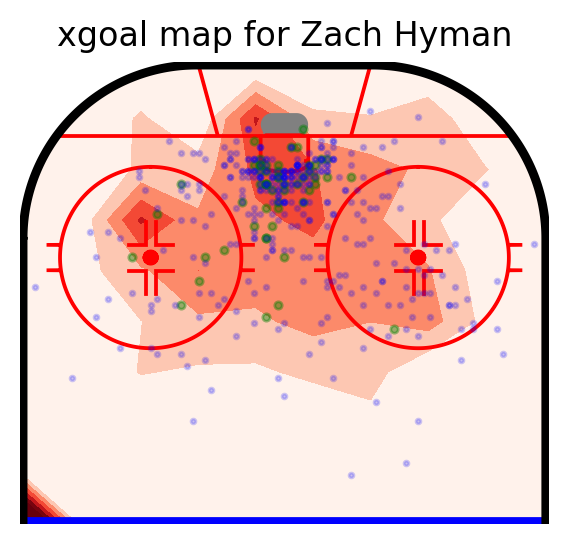

Alex Ovechkin scored 31 goals on 394 shots
Alex Ovechkin xgoals = 32.28876495361328


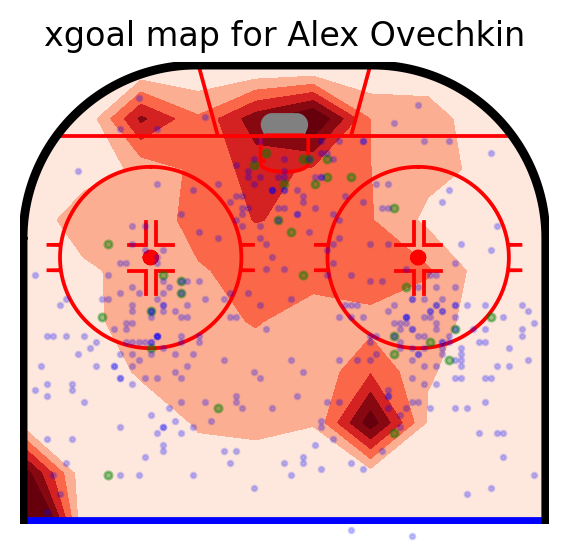

Erik Karlsson scored 11 goals on 312 shots
Erik Karlsson xgoals = 12.528474807739258


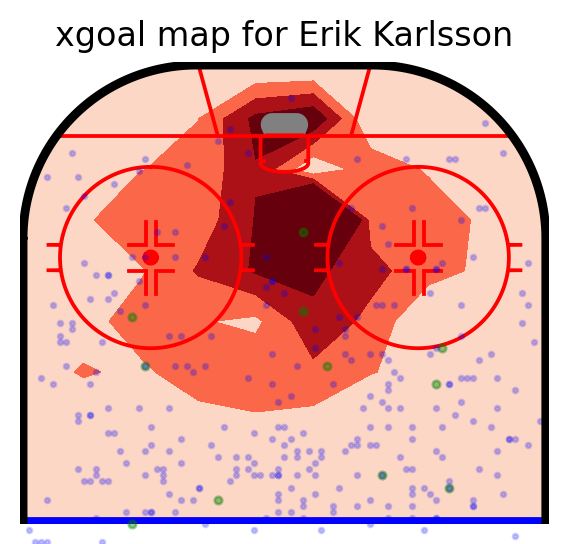

In [47]:
xgoal_player_map('Zach Hyman')
xgoal_player_map('Alex Ovechkin')
xgoal_player_map('Erik Karlsson')

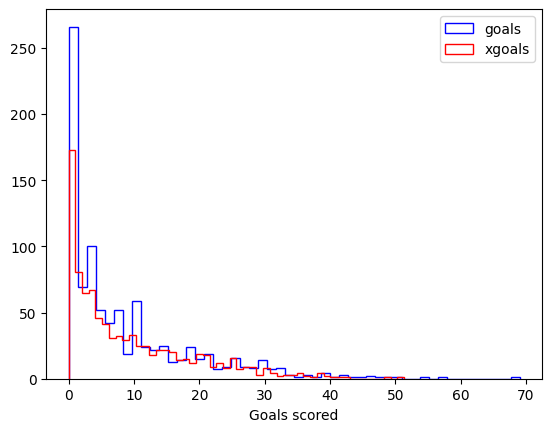

DescribeResult(nobs=919, minmax=(0, 69), mean=8.781284004352557, variance=105.43903930814255, skewness=1.6993178079257552, kurtosis=3.3185183182903764)
DescribeResult(nobs=919, minmax=(1.4115412e-05, 51.328514), mean=9.245658, variance=89.01184293958876, skewness=1.263569649747671, kurtosis=1.1702093318992288)


In [42]:
# plot distrubtions of xgoals and goals

bins__ = 50

plt.figure(dpi = 100)
plt.hist(grouped_pred['goal'], bins = bins__,histtype = 'step',color = 'blue',label = 'goals')
plt.hist(grouped_pred['pred_xgoal'], bins = bins__,histtype = 'step',color = 'red',label = 'xgoals')
plt.xlabel('Goals scored')
plt.legend()
plt.show()

print(describe(grouped_pred['goal']))
print(describe(grouped_pred['pred_xgoal']))

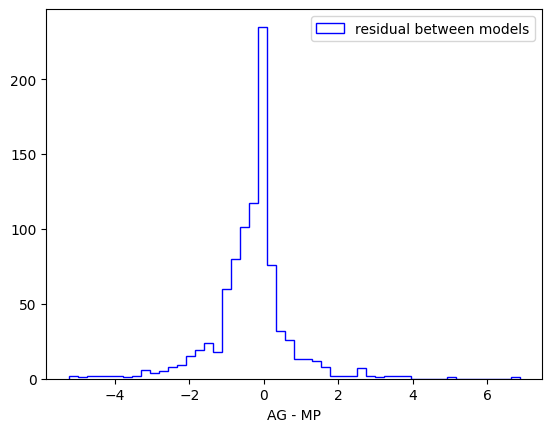

DescribeResult(nobs=919, minmax=(-5.2357981907324245, 6.861123795761721), mean=-0.3218758305294429, variance=1.1723267564748447, skewness=-0.021469520392498588, kurtosis=6.156979789110336)


In [43]:
plt.figure(dpi = 100)
plt.hist(grouped_pred['residual_difference'], bins = bins__,histtype = 'step',color = 'blue',label = 'residual between models')
plt.xlabel('AG - MP')
plt.legend()
plt.show()

print(describe(grouped_pred['residual_difference']))

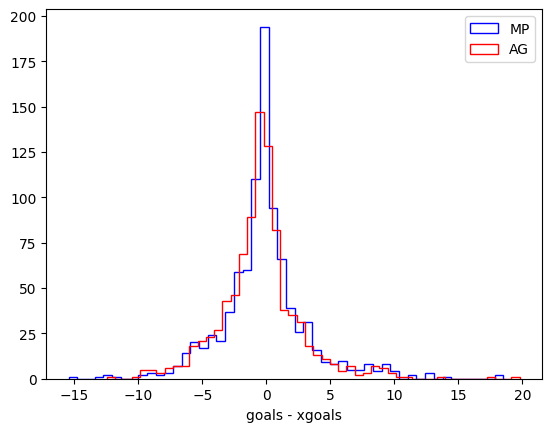

DescribeResult(nobs=919, minmax=(-15.443101640000002, 18.52486947), mean=-0.14249881436343856, variance=11.691029778978113, skewness=0.6108085510885576, kurtosis=4.05059671673825)
DescribeResult(nobs=919, minmax=(-12.449810028076172, 19.782909393310547), mean=-0.4643746448928814, variance=10.4487374267263, skewness=0.7285611490095316, kurtosis=4.2436437896544845)


In [44]:
plt.figure(dpi = 100)
plt.hist(grouped_pred['goal_residual'], bins = bins__,histtype = 'step',color = 'blue',label = 'MP')
plt.hist(grouped_pred['pred_goal_residual'], bins = bins__,histtype = 'step',color = 'red',label = 'AG')
plt.xlabel('goals - xgoals')
plt.legend()
plt.show()

print(describe(grouped_pred['goal_residual']))
print(describe(grouped_pred['pred_goal_residual']))

In [45]:
def xgoal_player_map(PLAYER):

    # plot for individual players
    rink = generate_rink_from_logo(home = 'NHL',away = 'NHL',rotation = 90)

    df_filtered = df[df['shooterName'] == PLAYER]

    goals_scored = np.sum(df_filtered['goal'])
    shots_taken = np.shape(df_filtered)[0]

    goal_coords_x,goal_coords_y = df_filtered[df_filtered['goal'] == 1][['arenaAdjustedXCord', 'arenaAdjustedYCord']].values.T
    shot_coords_x,shot_coords_y = df_filtered[df_filtered['goal'] == 0][['arenaAdjustedXCord', 'arenaAdjustedYCord']].values.T



    # get x,y coordinates and z = f(x,y)
    x_coords = np.abs(df_filtered['arenaAdjustedXCord'].values)
    y_coords = df_filtered['arenaAdjustedYCord'].values
    xgoal_values = df_filtered['pred_xgoal'].values

    total_xgoals = np.sum(xgoal_values)

    print(f'{PLAYER} scored {goals_scored} goals on {shots_taken} shots')
    print(f'{PLAYER} xgoals = {total_xgoals}')

    # use percentile to set vmin and vmax
    v_percentiles = [3,97]
    vmin_,vmax_ = np.percentile(xgoal_values,v_percentiles)

    # Create a 2D histogram
    # hist, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=500, weights=xgoal_values)

    # plot the xgoal map
    plt.figure(figsize=(4, 3), dpi=200)
    rink.contourf(x_coords,y_coords,xgoal_values,
                cmap = 'Reds',vmin = vmin_, vmax = vmax_,nbins = 10,levels = 10,
                draw_kw={"display_range": "ozone"},plot_range="ozone")
    plt.title(f'xgoal map for {PLAYER}')
    rink.scatter(np.abs(goal_coords_x),goal_coords_y, c = 'green', s = 7, alpha = 0.4)
    rink.scatter(np.abs(shot_coords_x),shot_coords_y, c = 'blue', s = 3, alpha = 0.2)
    plt.show()
    return

Erik Karlsson scored 11 goals on 312 shots
Erik Karlsson xgoals = 12.528474807739258


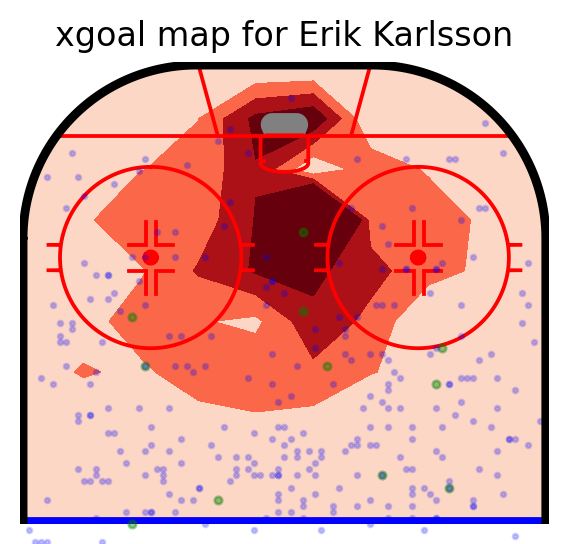

In [46]:
xgoal_player_map('Erik Karlsson')